In [6]:
import numpy as np

X = np.load("X.npy")
Y = np.load("Y.npy")

print("X shape:", X.shape, "dtype:", X.dtype)   # expect (N, H, W, C) or (N, H, W)
print("Y shape:", Y.shape, "dtype:", Y.dtype)   # expect (N,) or (N,10)
print("X min/max:", X.min(), X.max())
print("First 10 labels preview:", Y[:10])


X shape: (2062, 64, 64) dtype: float32
Y shape: (2062, 10) dtype: float64
X min/max: 0.003921569 1.0
First 10 labels preview: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [7]:
from sklearn.model_selection import train_test_split

# 1) Ensure channel dimension
if X.ndim == 3:  # (N, H, W)
    X = X[..., np.newaxis]  # -> (N, H, W, 1)

# 2) Normalize
X = X.astype("float32")
if X.max() > 1.0:
    X /= 255.0

# 3) Split (70/15/15)
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, Y, test_size=0.30, random_state=42, stratify=(Y.argmax(1) if Y.ndim == 2 else Y)
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=42, stratify=(y_tmp.argmax(1) if y_tmp.ndim == 2 else y_tmp)
)

print(X_train.shape, X_val.shape, X_test.shape)


(1443, 64, 64, 1) (309, 64, 64, 1) (310, 64, 64, 1)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = 10
input_shape = X_train.shape[1:]

# Decide loss based on label format
one_hot = (y_train.ndim == 2 and y_train.shape[1] == num_classes)
loss = "categorical_crossentropy" if one_hot else "sparse_categorical_crossentropy"

model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=12,
    batch_size=32
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,666 (4.36 MB)

 Trainable params: 1,142,666 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.0949 - loss: 2.3093 - val_accuracy: 0.1003 - val_loss: 2.2994
Epoch 2/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.2155 - loss: 2.1158 - val_accuracy: 0.5825 - val_loss: 1.3665
Epoch 3/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5793 - loss: 1.2249 - val_accuracy: 0.7152 - val_loss: 0.8028
Epoch 4/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7048 - loss: 0.8506 - val_accuracy: 0.8155 - val_loss: 0.6651
Epoch 5/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7796 - loss: 0.6527 - val_accuracy: 0.8447 - val_loss: 0.5209
Epoch 6/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8385 - loss: 0.5073 - val_accuracy: 0.8447 - val_loss: 0.5400
Epoch 7/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8600 - loss: 0.4505 - val_accuracy: 0.8544 - val_loss: 0.4521
Epoch 8/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8822 - loss: 0.3680 - val_accuracy: 0.8770 - v

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


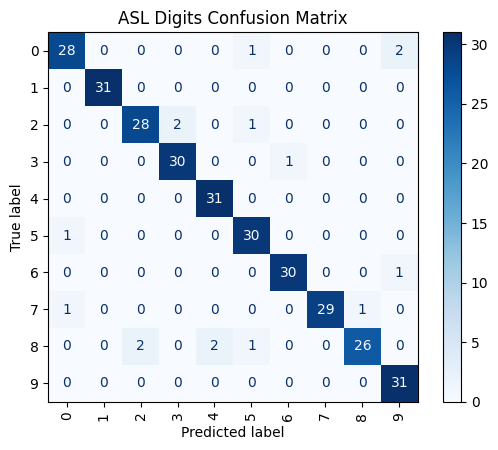

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predictions
probs = model.predict(X_test)
y_pred = probs.argmax(axis=1)

# True labels to class ids
y_true = y_test.argmax(axis=1) if (y_test.ndim == 2) else y_test

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("ASL Digits Confusion Matrix")
plt.show()


In [10]:
print("X:", X.shape, X.dtype, X.min(), X.max())
print("Y:", Y.shape, Y.dtype, "row sum:", Y[0].sum())
print("Train/Val/Test:", X_train.shape, X_val.shape, X_test.shape)


X: (2062, 64, 64, 1) float32 0.003921569 1.0
Y: (2062, 10) float64 row sum: 1.0
Train/Val/Test: (1443, 64, 64, 1) (309, 64, 64, 1) (310, 64, 64, 1)


In [15]:
Y_train = y_train.astype("float32")
Y_val   = y_val.astype("float32")
Y_test  = y_test.astype("float32")


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(64, 64, 1)),
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(10, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.1441 - loss: 2.2882 - val_accuracy: 0.3592 - val_loss: 2.1080
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.4934 - loss: 1.4869 - val_accuracy: 0.7508 - val_loss: 0.8398
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.6895 - loss: 0.8793 - val_accuracy: 0.8317 - val_loss: 0.6214
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.7817 - loss: 0.6429 - val_accuracy: 0.8511 - val_loss: 0.4625
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.8455 - loss: 0.4579 - val_accuracy: 0.8511 - val_loss: 0.4202
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8753 - loss: 0.3761 - val_accuracy: 0.8544 - val_loss: 0.3985
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8947 - loss: 0.3398 - val_accuracy: 0.8964 - val_loss: 0.3533
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9009 - loss: 0.3126 - val_accuracy: 0.9159 - v

In [17]:
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")


Test accuracy: 0.9323 | Test loss: 0.1964


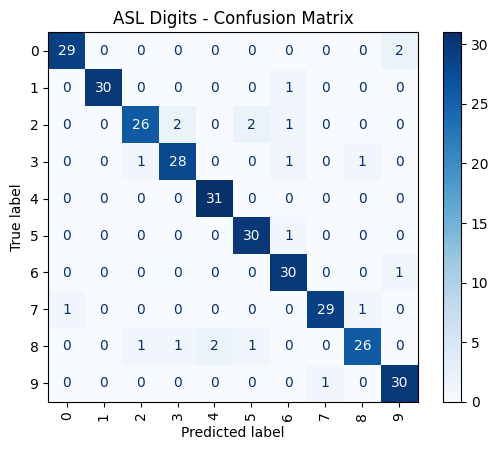

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert one-hot -> class id
y_true = Y_test.argmax(axis=1)

# Predict -> class id
probs = model.predict(X_test, verbose=0)
y_pred = probs.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("ASL Digits - Confusion Matrix")
plt.show()


In [20]:
_ = model(X_train[:1])   # builds the graph by running a forward pass once


In [21]:
import tensorflow as tf

conv_layers = [l for l in model.layers if isinstance(l, tf.keras.layers.Conv2D)]
activation_model = tf.keras.Model(inputs=model.inputs, outputs=[l.output for l in conv_layers])


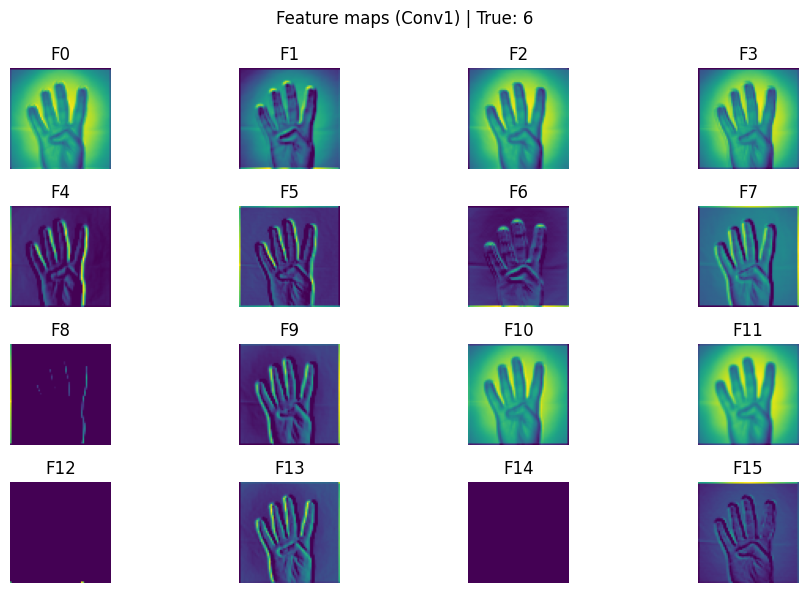

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 1) Pick one sample
idx = 0
sample = X_test[idx:idx+1]                 # shape (1, 64, 64, 1)
true_digit = int(Y_test[idx].argmax())

# 2) Choose conv layers to inspect


conv_layers = [l for l in model.layers if isinstance(l, tf.keras.layers.Conv2D)]
activation_model = tf.keras.Model(inputs=model.inputs, outputs=[l.output for l in conv_layers])
 # intermediate outputs [web:124]

activations = activation_model.predict(sample, verbose=0)

# 3) Plot: first conv layer feature maps (first 16 channels)
first = activations[0]                      # (1, H, W, channels)
n_maps = min(first.shape[-1], 16)

plt.figure(figsize=(10, 6))
for i in range(n_maps):
    ax = plt.subplot(4, 4, i+1)
    ax.imshow(first[0, :, :, i], cmap="viridis")
    ax.set_title(f"F{i}")
    ax.axis("off")
plt.suptitle(f"Feature maps (Conv1) | True: {true_digit}")
plt.tight_layout()
plt.show()


Misclassified: 21 out of 310


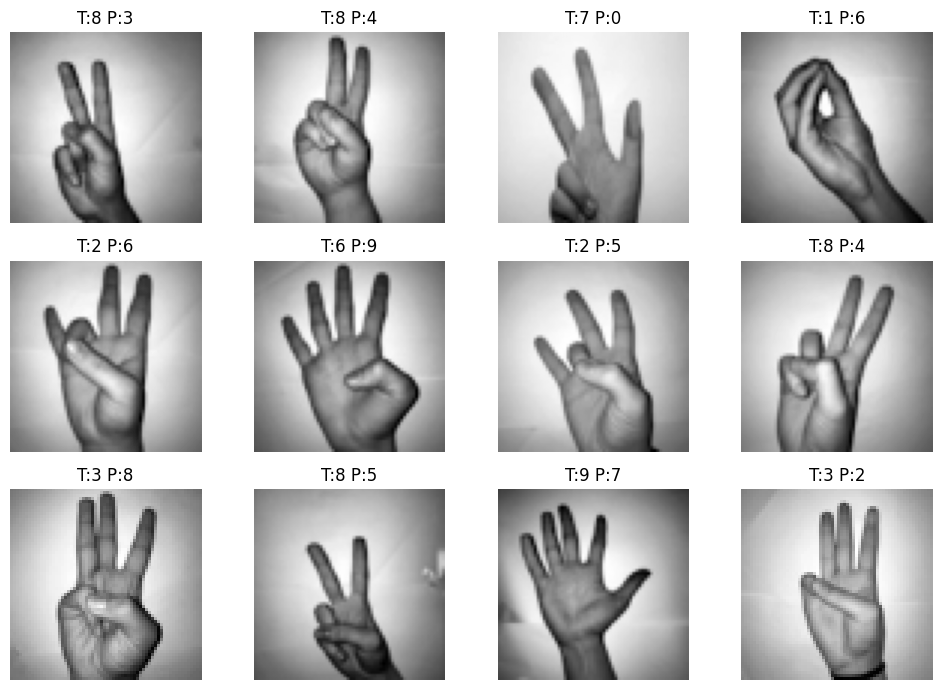

In [24]:
import numpy as np
import matplotlib.pyplot as plt

probs = model.predict(X_test, verbose=0)
y_true = Y_test.argmax(axis=1)
y_pred = probs.argmax(axis=1)

wrong_idx = np.where(y_true != y_pred)[0]
print("Misclassified:", len(wrong_idx), "out of", len(y_true))

show_n = min(12, len(wrong_idx))
plt.figure(figsize=(10, 7))
for i, idx in enumerate(wrong_idx[:show_n]):
    ax = plt.subplot(3, 4, i+1)
    ax.imshow(X_test[idx].squeeze(), cmap="gray")
    ax.set_title(f"T:{y_true[idx]} P:{y_pred[idx]}")
    ax.axis("off")
plt.tight_layout()
plt.show()


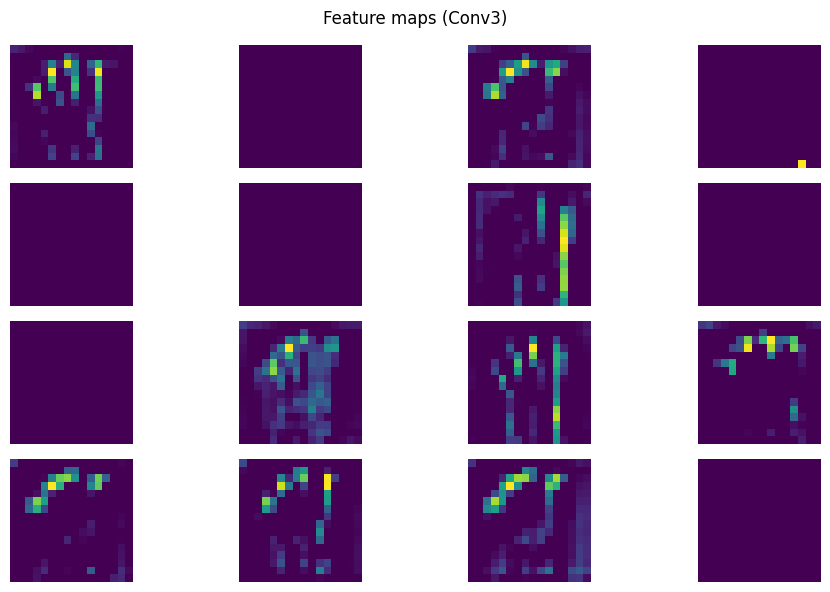

In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt

_ = model(X_test[:1])  # ensure built

conv_layers = [l for l in model.layers if isinstance(l, tf.keras.layers.Conv2D)]
activation_model = tf.keras.Model(model.inputs, [l.output for l in conv_layers])

idx = 0
sample = X_test[idx:idx+1]
acts = activation_model.predict(sample, verbose=0)

# Pick which conv layer to visualize: 0=Conv1, 1=Conv2, 2=Conv3
layer_k = 2
fm = acts[layer_k]  # (1, H, W, C)

n_maps = min(fm.shape[-1], 16)
plt.figure(figsize=(10, 6))
for i in range(n_maps):
    ax = plt.subplot(4, 4, i+1)
    ax.imshow(fm[0, :, :, i], cmap="viridis")
    ax.axis("off")
plt.suptitle(f"Feature maps (Conv{layer_k+1})")
plt.tight_layout()
plt.show()


In [26]:
import os
os.makedirs("models", exist_ok=True)

model.save("models/asl_digits_cnn.keras")


In [34]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# ---- assumes you already have these in memory ----
# X_train, Y_train, X_val, Y_val, X_test, Y_test
# Shapes: (N,64,64,1) and one-hot labels (N,10)

# Ensure dtype consistency
Y_train = Y_train.astype("float32")
Y_val   = Y_val.astype("float32")
Y_test  = Y_test.astype("float32")

data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.10),
])

aug_model = models.Sequential([
    layers.Input(shape=(64, 64, 1)),
    data_aug,

    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(10, activation="softmax"),
])

aug_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

history = aug_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=25,
    batch_size=32,
    callbacks=[early_stop]
)

# Test evaluation
test_loss, test_acc = aug_model.evaluate(X_test, Y_test, verbose=0)
print(f"[Aug Model] Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

# Save in .keras format (recommended)
os.makedirs("models", exist_ok=True)
aug_model.save("models/asl_digits_aug.keras")
print("Saved: models/asl_digits_aug.keras")


Epoch 1/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.0825 - loss: 2.3077 - val_accuracy: 0.1003 - val_loss: 2.3021
Epoch 2/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.0977 - loss: 2.3034 - val_accuracy: 0.1003 - val_loss: 2.3018
Epoch 3/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.1247 - loss: 2.2979 - val_accuracy: 0.1003 - val_loss: 2.2596
Epoch 4/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.1864 - loss: 2.1838 - val_accuracy: 0.4175 - val_loss: 1.7909
Epoch 5/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.3396 - loss: 1.8334 - val_accuracy: 0.6117 - val_loss: 1.2598
Epoch 6/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.4491 - loss: 1.5480 - val_accuracy: 0.6634 - val_loss: 1.0428
Epoch 7/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5468 - loss: 1.2876 - val_accuracy: 0.7799 - val_loss: 0.7354
Epoch 8/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6313 - loss: 1.0603 - val_accuracy: 0.8220 - v

In [36]:
import cv2
import numpy as np
import tensorflow as tf

MODEL_PATH = "models/asl_digits_aug.keras"  # use augmented model
CONF_THRESH = 0.75
TOPK = 3

model = tf.keras.models.load_model(MODEL_PATH)

def preprocess_roi(roi_bgr):
    gray = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2GRAY)  # BGR -> Gray [web:228]
    gray = cv2.resize(gray, (64, 64)).astype("float32") / 255.0
    x = gray[np.newaxis, ..., np.newaxis]  # (1,64,64,1)
    return x, gray

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()  # ret indicates success [web:224]
    if not ret:
        break

    h, w = frame.shape[:2]

    # ROI box (fixed size, top-right-ish; easy for user)
    box = int(min(h, w) * 0.45)
    x1, y1 = w - box - 20, 20
    x2, y2 = w - 20, 20 + box

    roi = frame[y1:y2, x1:x2].copy()

    x, gray64 = preprocess_roi(roi)

    probs = model.predict(x, verbose=0)[0]
    topk_idx = probs.argsort()[-TOPK:][::-1]

    pred = int(topk_idx[0])
    conf = float(probs[topk_idx[0]])

    if conf < CONF_THRESH:
        line1 = f"Uncertain ({conf:.2f}) - keep hand inside box"
    else:
        line1 = f"Digit: {pred} ({conf:.2f})"

    alts = ", ".join([f"{int(i)}:{probs[i]:.2f}" for i in topk_idx[1:]])
    line2 = f"Alt: {alts}" if TOPK > 1 else ""

    # Draw ROI box + text
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)  # ROI rectangle [web:286]
    cv2.putText(frame, line1, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
    cv2.putText(frame, line2, (20, 75), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    cv2.imshow("ASL Digits (Webcam)", frame)
    cv2.imshow("Model Input (64x64)", (gray64 * 255).astype("uint8"))

    key = cv2.waitKey(1) & 0xFF  # for quitting [web:230]
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [32]:
probs = model.predict(x, verbose=0)[0]
top3 = probs.argsort()[-3:][::-1]

print([(int(k), float(probs[k])) for k in top3])


[(7, 0.9531381726264954), (1, 0.022746510803699493), (4, 0.01770142652094364)]
